In this notebook, we will be studying the susceptibility of the commonly used optimizers to adversarial perturbations. We will be using a pre-trained ResNet50 and we will be working with a targeted attack as shown [in this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/attacks/02_1_targeted_pgd.ipynb). 

## Initial setup and imports

In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.3.0


We first download a sample image which we will perturb in order to fool our pre-trained image classifier. We also download a dictionary that contains the mapping between the Imagenet dataset class labels and their ids (the ResNet50 model is pre-trained on ImageNet).

In [2]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

## A few early constants

In [3]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

## Utility functions

Next we define a couple of utility functions that we will be using throughout the course of this notebook.

In [4]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels, preprocess=False):
    if preprocess:
        image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

## Loading our first image and pre-trained model

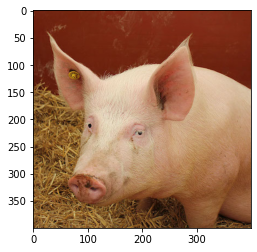

In [5]:
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

## Running inference with a pre-trained model

In [6]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

Predicted: [('n02395406', 'hog', 0.99968374), ('n02396427', 'wild_boar', 0.00031595054), ('n03935335', 'piggy_bank', 9.8273716e-08)]
Class idx: 341


Let's now write our utility functions for launching a targeted PGD-based attack.

## Utility functions for adversarial attacks

In this attack we will use PGD to simply maximize the loss for the given (true) class and at the same time minimize the loss for the target class such that the visual semantics of our input image does not get hampered.

In [7]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_index, optimizer):
    # Loss function
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true, target, model, optimizer):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
                                                 true, target, optimizer)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=3)[0])


Note that the hyperparameters like learning rate, number of epochs were determined after empirical experiments and also by referring to [this tremendous tutorial](https://adversarial-ml-tutorial.org/introduction/).

## Comparing different optimizers

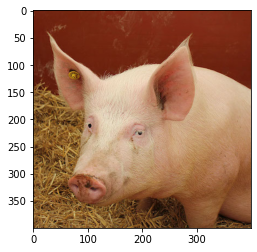

Prediction before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.0003111297), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.115244
40 16.094204
60 13.44788
80 9.234088
100 6.442647
120 4.5409727
140 3.13931
160 1.91612
180 0.90275526
200 0.016634941
220 -0.79472923
240 -1.5573258
260 -2.2561917
280 -2.8983536
300 -3.5415752
320 -4.161685
340 -4.7747116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


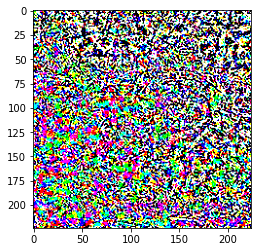

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


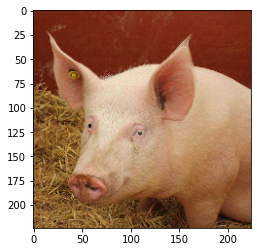

Prediction after adv.: [('n02095570', 'Lakeland_terrier', 0.07232616), ('n01883070', 'wombat', 0.036618), ('n02098286', 'West_Highland_white_terrier', 0.034542628)]


In [8]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
perturb_image("pig.jpg", 341, 189, resnet50, optimizer)

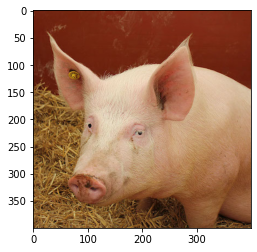

Prediction before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.0003111297), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.117777
40 16.115356
60 16.106232
80 16.085676
100 15.439515
120 14.120703
140 13.064412
160 12.206408
180 11.522441
200 10.963722
220 10.523318
240 10.179905
260 9.902494
280 9.670608
300 9.460307
320 9.28924
340 9.150984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


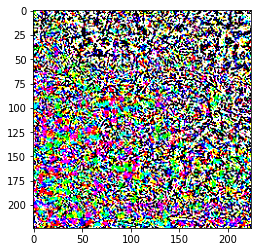

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


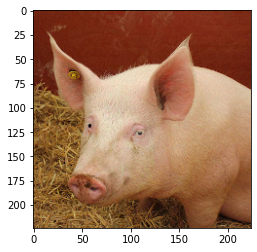

Prediction after adv.: [('n02395406', 'hog', 0.4756599), ('n02396427', 'wild_boar', 0.2500323), ('n01883070', 'wombat', 0.11435015)]


In [9]:
#@title SGD
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3)
perturb_image("pig.jpg", 341, 189, resnet50, optimizer)

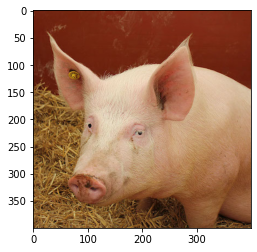

Prediction before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.0003111297), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.104506
40 13.415277
60 9.754022
80 7.2518644
100 5.374225
120 3.956086
140 2.7145386
160 1.6448693
180 0.65841436
200 -0.24283028
220 -1.0577755
240 -1.7797747
260 -2.4795985
280 -3.14384
300 -3.788152
320 -4.4277983
340 -5.0820293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


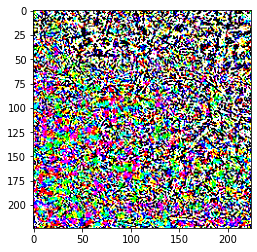

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


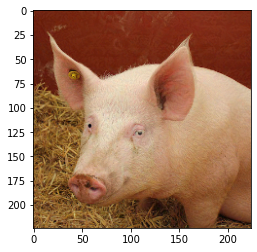

Prediction after adv.: [('n02095570', 'Lakeland_terrier', 0.05796261), ('n04557648', 'water_bottle', 0.044212814), ('n01883070', 'wombat', 0.030314619)]


In [10]:
#@title RMSprop
optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-3)
perturb_image("pig.jpg", 341, 189, resnet50, optimizer)

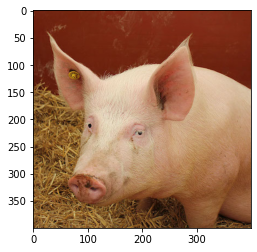

Prediction before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.0003111297), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.117762
40 16.11492
60 16.104982
80 16.08331
100 15.311319
120 14.017033
140 12.979907
160 12.132413
180 11.46163
200 10.913521
220 10.479566
240 10.143829
260 9.868805
280 9.639973
300 9.430887
320 9.261969
340 9.124548


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


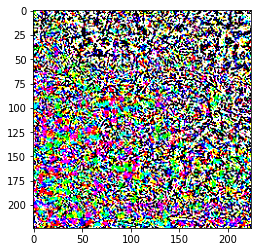

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


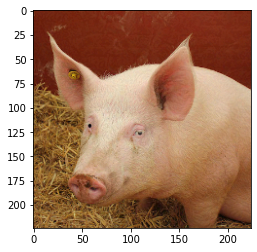

Prediction after adv.: [('n02395406', 'hog', 0.47346646), ('n02396427', 'wild_boar', 0.24976428), ('n01883070', 'wombat', 0.115148395)]


In [11]:
#@title Adagrad
optimizer = tf.keras.optimizers.Adagrad(learning_rate=5e-3)
perturb_image("pig.jpg", 341, 189, resnet50, optimizer)

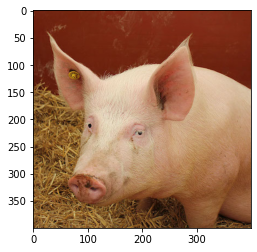

Prediction before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.0003111297), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 16.117785
20 16.117785
40 16.117785
60 16.117785
80 16.117785
100 16.117785
120 16.117783
140 16.117785
160 16.117785
180 16.117785
200 16.117785
220 16.117785
240 16.117783
260 16.117785
280 16.117785
300 16.117785
320 16.117785
340 16.117785


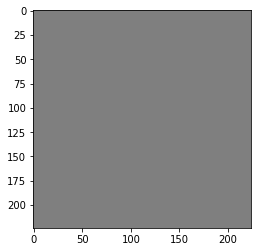

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


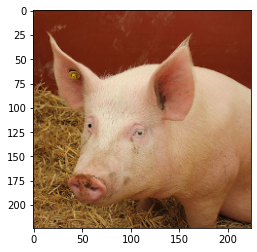

Prediction after adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.00031113205), ('n03935335', 'piggy_bank', 8.920601e-08)]


In [12]:
#@title FTRL
optimizer = tf.keras.optimizers.Ftrl(learning_rate=5e-3)
perturb_image("pig.jpg", 341, 189, resnet50, optimizer)